In [ ]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
import shap

## Load and split data

In [2]:
train_dir = "train_cleaned.csv"
train_data = pd.read_csv(train_dir)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Columns: 107 entries, Available Extra Rooms in Hospital to City_Code_Patient_9
dtypes: bool(99), float64(7), int64(1)
memory usage: 49.5 MB


In [3]:
#split our train and test and label
X = train_data.drop(columns=['Stay'])
y = train_data['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)      

In [ ]:
# Identify boolean columns
bool_columns = train_data.select_dtypes(include=['bool']).columns

# Convert boolean values to 0 and 1
train_data[bool_columns] = train_data[bool_columns].astype(int)



SMOTE resampling

In [ ]:
# Create the SMOTE object
smote = SMOTE(random_state=42)

# Apply SMOTE to training data only
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


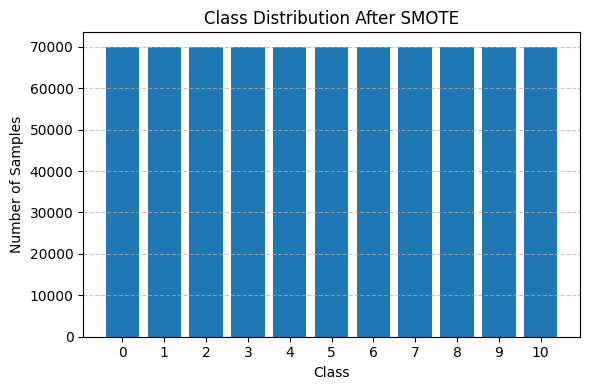

In [ ]:
# Count the number of samples in each class
resampled_counts = pd.Series(y_train_resampled).value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(6, 4))
plt.bar(resampled_counts.index.astype(str), resampled_counts.values)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Logistic Regression

In [4]:
#call the Logisitic Regression function 
log_reg = LogisticRegression(max_iter=200, solver='saga', n_jobs=1)
log_reg.fit(X_train, y_train)  


y_pred_log_reg = log_reg.predict(X_test)  


print("Logistic Regression (All Features)")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))  

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg)) 

Logistic Regression (All Features)
Accuracy: 0.39927458861952014

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.07      0.11      4721
           1       0.41      0.47      0.44     15628
           2       0.42      0.68      0.51     17498
           3       0.33      0.20      0.25     11032
           4       0.00      0.00      0.00      2349
           5       0.37      0.47      0.41      7004
           6       0.00      0.00      0.00       549
           7       0.00      0.00      0.00      2051
           8       0.00      0.00      0.00       967
           9       0.00      0.00      0.00       553
          10       0.55      0.34      0.42      1336

    accuracy                           0.40     63688
   macro avg       0.23      0.20      0.19     63688
weighted avg       0.36      0.40      0.35     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [ ]:
#display accuracy stats
precision = precision_score(y_test, y_pred_log_reg, average='weighted')
recall = recall_score(y_test, y_pred_log_reg, average='weighted')
f1 = f1_score(y_test, y_pred_log_reg, average='weighted')

print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")


Precision: 0.36
Recall:    0.40
F1 Score:  0.35


c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


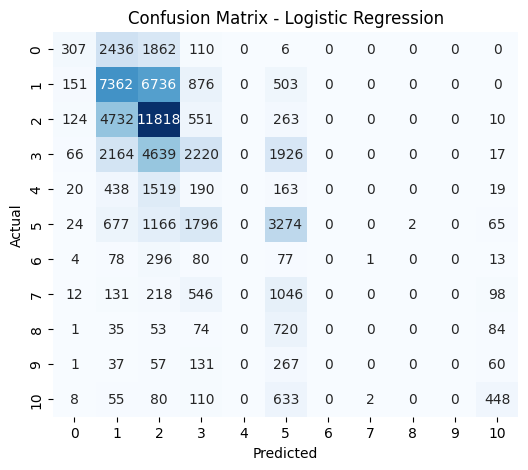

In [ ]:
#display the confusion matrix for logisitic regression
cm = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


In [ ]:
# Binarize labels for multiclass, in order to show the ROC for each class
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_proba = log_reg.predict_proba(X_test)

auc_score = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
print(f"Multiclass ROC AUC Score: {auc_score:.2f}")


Multiclass ROC AUC Score: 0.77


In [13]:
y_proba = log_reg.predict_proba(X_test)
print("Shape of y_proba:", y_proba.shape)


Shape of y_proba: (63688, 11)


In [14]:
y_scores = y_proba[:, 1]  # Probability for the positive class


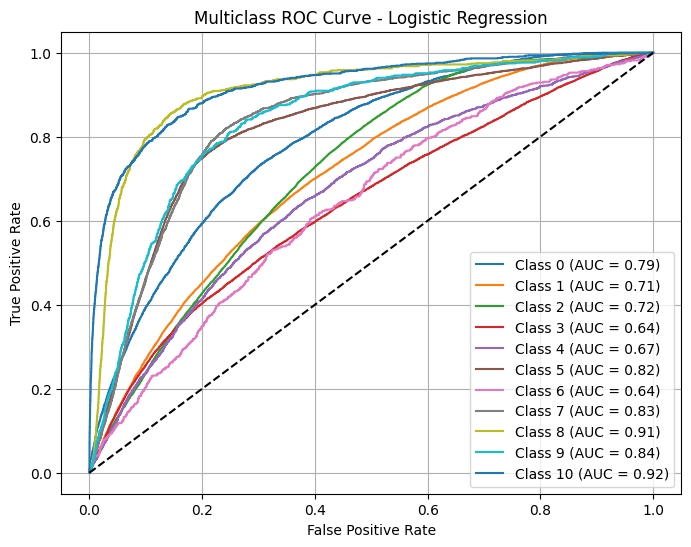

In [ ]:
#plot the ROC CUrve for each class
plt.figure(figsize=(8, 6))

for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()



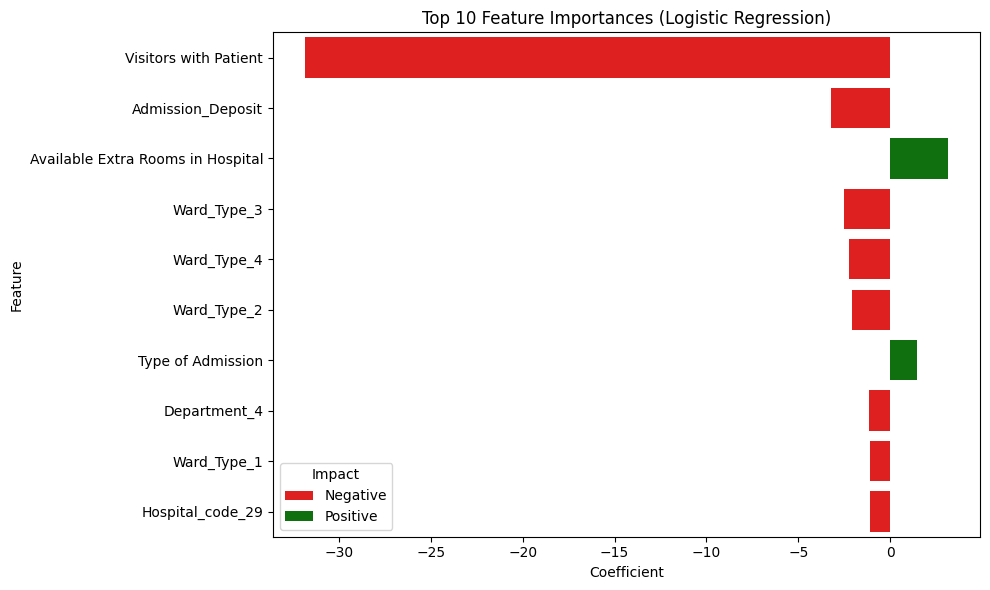

In [ ]:
#plt the important features for the logisitic regression
coef_df["Impact"] = coef_df["Coefficient"].apply(lambda x: "Positive" if x > 0 else "Negative")

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Coefficient", y="Feature", data=coef_df.head(10),
    hue="Impact", dodge=False, palette={"Positive": "green", "Negative": "red"}
)
plt.title("Top 10 Feature Importances (Logistic Regression)")
plt.legend(title="Impact")
plt.tight_layout()
plt.show()


c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\

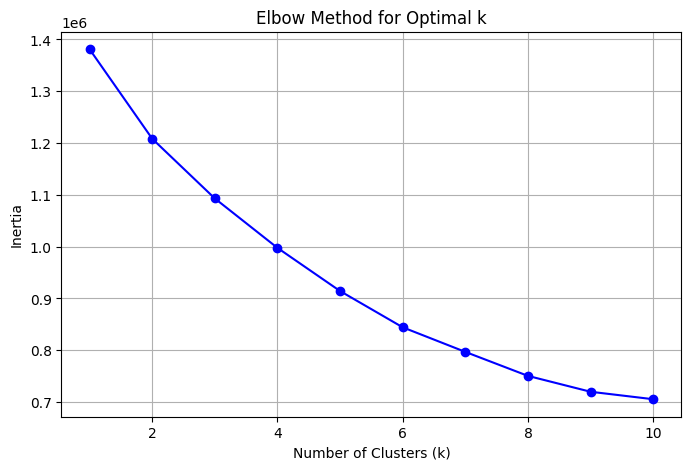

In [ ]:
#find the perfect amount of clusters via elbow method
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train) 
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


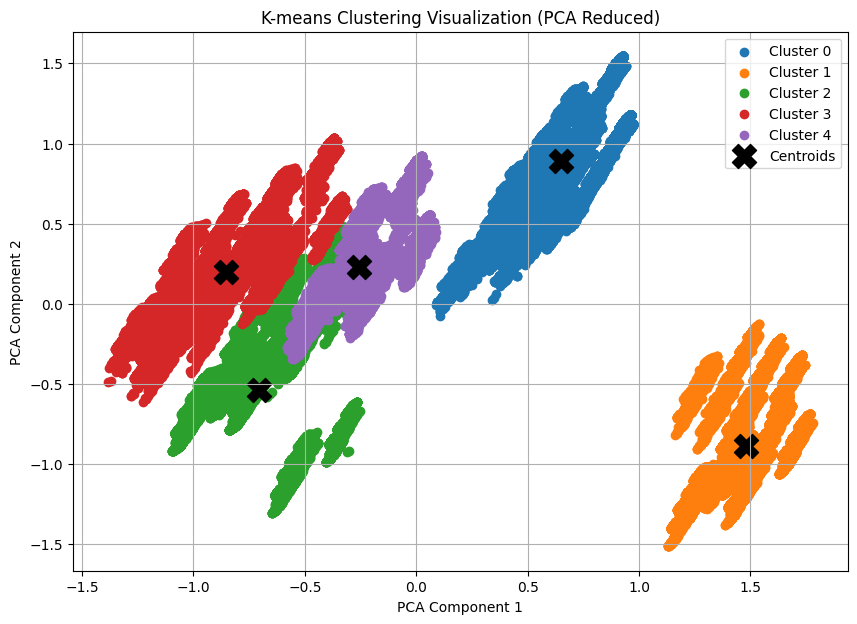

In [ ]:
#use optimal k to perform Kmeans and use PCA to plot it in a readable way
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  

clusters = kmeans.fit_predict(X_train)


feature_names = train_data.drop(columns=['Stay']).columns 
X_train_scaled_df = pd.DataFrame(X_train, columns=feature_names)

X_train_scaled_df['Cluster'] = clusters


pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_train)


X_train_scaled_df['PCA1'] = pca_components[:, 0]
X_train_scaled_df['PCA2'] = pca_components[:, 1]


plt.figure(figsize=(10, 7))

for cluster in range(optimal_k):
    plt.scatter(
        X_train_scaled_df[X_train_scaled_df['Cluster'] == cluster]['PCA1'],
        X_train_scaled_df[X_train_scaled_df['Cluster'] == cluster]['PCA2'],
        label=f'Cluster {cluster}'
    )


centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], s=300, c='black', marker='X', label='Centroids')

plt.title('K-means Clustering Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Use a makeshift function to see how well the cluster performed 
#if the custers labeled the correct amount of stay then its correct
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(X_train)  


y_pred_clusters = kmeans.predict(X_test)  


labels_map = {}


for cluster in range(10):
    mask = (kmeans.labels_ == cluster)  
    if np.sum(mask) > 0:
        majority_label = mode(y_train[mask], keepdims=True).mode[0]  
        labels_map[cluster] = majority_label

y_pred_mapped = np.array([labels_map[cluster] for cluster in y_pred_clusters])


accuracy = accuracy_score(y_test, y_pred_mapped)
print(f'K-Means Clustering Accuracy: {accuracy:.2f}')


print("\nClassification Report:")
print(classification_report(y_test, y_pred_mapped))




c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Clustering Accuracy: 0.29

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      4721
           1       0.31      0.24      0.27     15628
           2       0.28      0.84      0.42     17498
           3       0.00      0.00      0.00     11032
           4       0.00      0.00      0.00      2349
           5       0.00      0.00      0.00      7004
           6       0.00      0.00      0.00       549
           7       0.00      0.00      0.00      2051
           8       0.00      0.00      0.00       967
           9       0.00      0.00      0.00       553
          10       0.00      0.00      0.00      1336

    accuracy                           0.29     63688
   macro avg       0.05      0.10      0.06     63688
weighted avg       0.15      0.29      0.18     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Random Forest

In [ ]:
#a basic random forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)  


y_pred = rf_classifier.predict(X_test)  


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.38

Classification Report:
              precision    recall  f1-score   support

           0       0.28      0.17      0.21      4721
           1       0.39      0.44      0.41     15628
           2       0.41      0.53      0.46     17498
           3       0.33      0.28      0.30     11032
           4       0.08      0.02      0.04      2349
           5       0.38      0.45      0.41      7004
           6       0.07      0.02      0.03       549
           7       0.26      0.10      0.14      2051
           8       0.39      0.18      0.25       967
           9       0.28      0.07      0.11       553
          10       0.55      0.43      0.48      1336

    accuracy                           0.38     63688
   macro avg       0.31      0.24      0.26     63688
weighted avg       0.36      0.38      0.36     63688



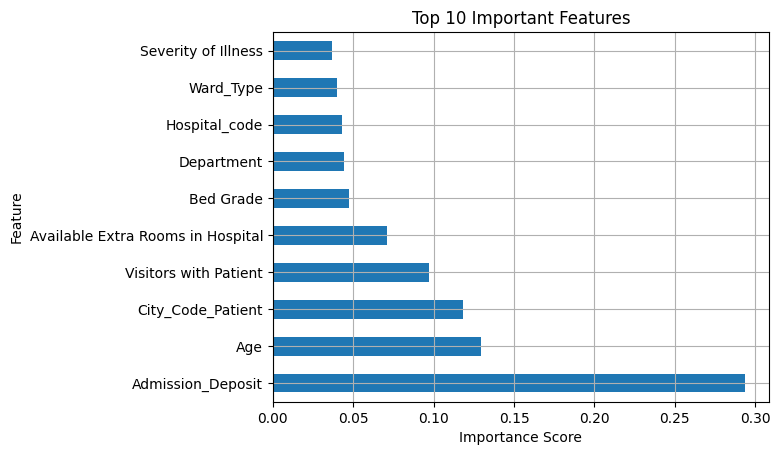

In [ ]:
#the original cleaning dataset used, and the feature important for it
feature_names = train_data.drop(columns=['Stay']).columns  


X_test_final_df = pd.DataFrame(X_test_scaled, columns=feature_names)


feature_importances = pd.Series(rf_classifier.feature_importances_, index=X_test_final_df.columns)
feature_importances.nlargest(10).plot(kind='barh')


plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.grid(True)
plt.show()

### HPO Tuning

In [ ]:
# Define hyperparameters to tune
#This was the OG dataset
param_grid = {
    'n_estimators': [50, 100, 200],        
    'max_depth': [None, 10, 20, 30],       
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4],        
    'max_features': ['sqrt', 'log2'],      
}

# Initialize Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=5,  # 5-Fold Cross Validation
    n_jobs=-1,
    verbose=2
)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Best Parameters
print("Best Parameters:", grid_search.best_params_)

# Evaluate Best Model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

In [4]:
#fit the RF based on the HPO (I had to run it on my PC )
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)


rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.42

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.08      0.13      4721
           1       0.43      0.50      0.46     15628
           2       0.42      0.68      0.52     17498
           3       0.43      0.22      0.29     11032
           4       0.00      0.00      0.00      2349
           5       0.39      0.53      0.45      7004
           6       0.00      0.00      0.00       549
           7       0.71      0.00      0.00      2051
           8       0.86      0.01      0.01       967
           9       0.00      0.00      0.00       553
          10       0.61      0.33      0.43      1336

    accuracy                           0.42     63688
   macro avg       0.39      0.21      0.21     63688
weighted avg       0.42      0.42      0.37     63688



c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\jayjo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo


Confusion Matrix for Random Forest:
[[  359  2352  1983    17     0    10     0     0     0     0     0]
 [  143  7754  6550   664     0   517     0     0     0     0     0]
 [  103  4918 11942   214     0   313     0     0     0     0     8]
 [   68  1829  4789  2479     0  1853     0     0     0     0    14]
 [   29   412  1577   116     0   205     0     0     0     0    10]
 [   34   512  1163  1543     0  3703     0     1     0     0    48]
 [    7    74   313    43     0   100     0     0     0     0    12]
 [   15    95   250   384     0  1212     0     5     1     0    89]
 [    3    37    52   109     0   714     0     0     6     0    46]
 [    1    19    68   103     0   308     0     0     0     0    54]
 [   14    43    81   109     0   645     0     1     0     0   443]]


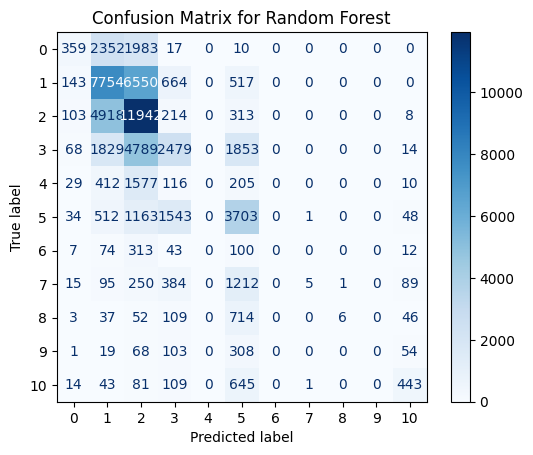

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("\nConfusion Matrix for Random Forest:")
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")
plt.show()


In [ ]:
# Save the model to a file
joblib.dump(rf_classifier, 'random_forest_model.pkl')


['random_forest_model.pkl']

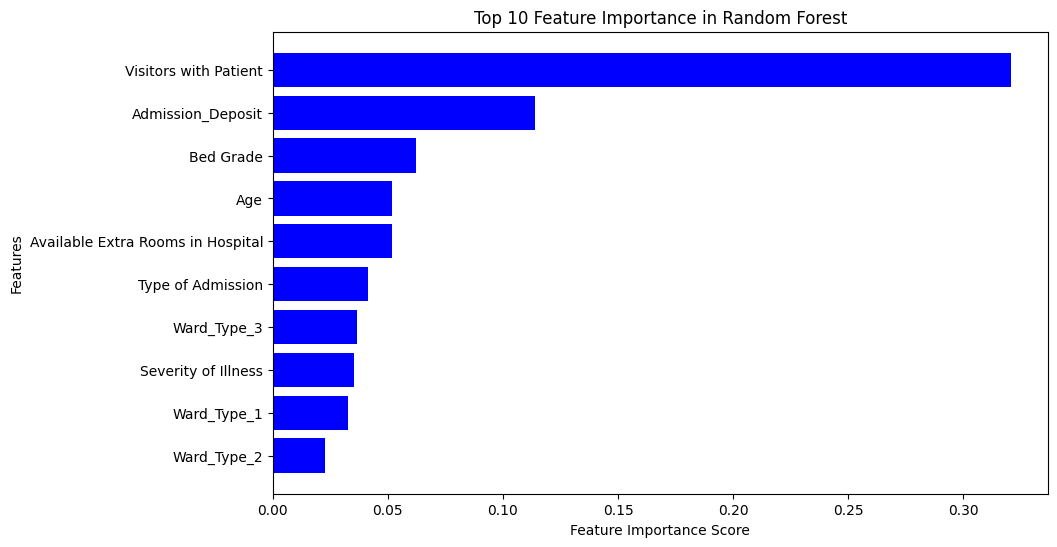

In [ ]:
#New dataset
# Extract feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': X_test_final_df.columns, 'Importance': feature_importances})

# Sort features by importance and select top 10
top_10_features = feature_importance_df.nlargest(10, 'Importance')

# Plot top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='blue')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Top 10 Feature Importance in Random Forest')
plt.gca().invert_yaxis()  # Show the most important feature on top
plt.show()


Testing the model with the test data set from the competiton

In [ ]:
# Save the model
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_classifier, file)

# Load the model
with open('random_forest_model.pkl', 'rb') as file:
    rf_classifier_loaded = pickle.load(file)


In [ ]:
df = pd.read_excel('test_cleaned.xlsx')

In [ ]:
# Suppose the label column is named 'target'
X_new = df

In [10]:
case_ids = df['case_id']
X_new = X_new.drop(columns=['case_id'])

In [ ]:
# Predict using the loaded model
y_pred = rf_classifier.predict(X_new)

In [33]:
stay_mapping = {
    0: "0-10",
    1: "11-20",
    2: "21-30",
    3: "31-40",
    4: "41-50",
    5: "51-60",
    6: "61-70",
    7: "71-80",
    8: "81-90",
    9: "91-100",
    10: "More than 100"
}

y_pred_labels = [stay_mapping[pred] for pred in y_pred] 
predictions_df = pd.DataFrame({
    "case_id": case_ids,
    "Stay": y_pred_labels
})

predictions_df.to_csv("predictions.csv", index=False)

Testing SMOTE

In [6]:
#fit the RF based on the HPO (I had to run it on my PC )
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)


rf_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = rf_classifier.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.39

Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.38      0.31      4721
           1       0.44      0.45      0.44     15628
           2       0.44      0.55      0.49     17498
           3       0.45      0.14      0.22     11032
           4       0.12      0.10      0.11      2349
           5       0.39      0.40      0.39      7004
           6       0.05      0.06      0.05       549
           7       0.20      0.16      0.18      2051
           8       0.25      0.49      0.33       967
           9       0.09      0.11      0.10       553
          10       0.41      0.51      0.45      1336

    accuracy                           0.39     63688
   macro avg       0.28      0.30      0.28     63688
weighted avg       0.39      0.39      0.37     63688




Confusion Matrix for SMOTE Random Forest:
[[1815 1478 1239   17  119   12   23    4    2    8    4]
 [2075 7008 4853  492  302  615   83   90   38   42   30]
 [1582 4746 9579  209  672  223  238   42  117   36   54]
 [ 742 1683 3577 1595  452 2050  140  331  223  116  123]
 [ 207  408 1095   73  229  156   63   26   36   22   34]
 [ 278  414  792  850  104 2774   56  613  579  247  297]
 [  43   76  203   28   40   60   32   13   25   11   18]
 [  71   80  156  171   33  751   16  324  130  122  197]
 [  21   25   34   25    4  167    4   33  477   19  158]
 [   8   21   45   42    8  180    8   74   28   63   76]
 [  39   20   43   37    8  170    8   61  231   37  682]]


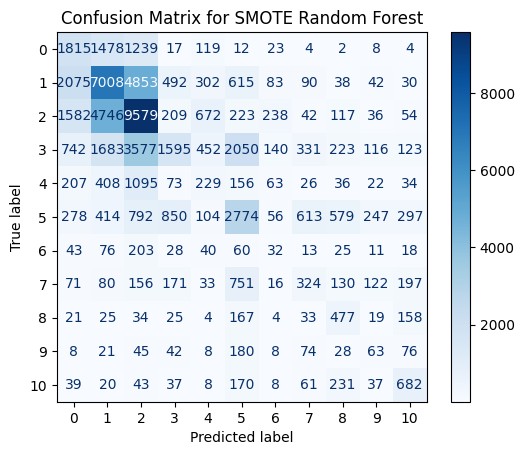

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)


print("\nConfusion Matrix for SMOTE Random Forest:")
print(cm)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SMOTE Random Forest")
plt.show()

In [12]:
# Convert all bool columns to int (0 and 1)
X_train_clean = X_train_resampled.copy()
X_test_clean = X_test.copy()

X_train_clean = X_train_clean.astype({col: int for col in X_train_clean.select_dtypes(bool).columns})
X_test_clean = X_test_clean.astype({col: int for col in X_test_clean.select_dtypes(bool).columns})


PermutationExplainer explainer: 101it [00:51,  1.74it/s]                         

 SHAP values shape: (100, 106, 11)

🔹 Class 0 SHAP Summary with SMOTE


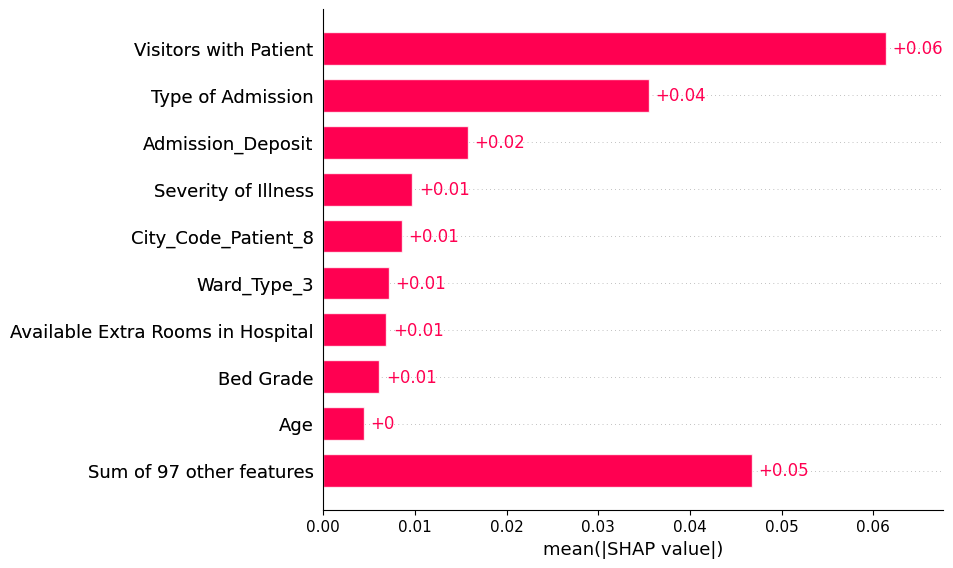


🔹 Class 1 SHAP Summary with SMOTE


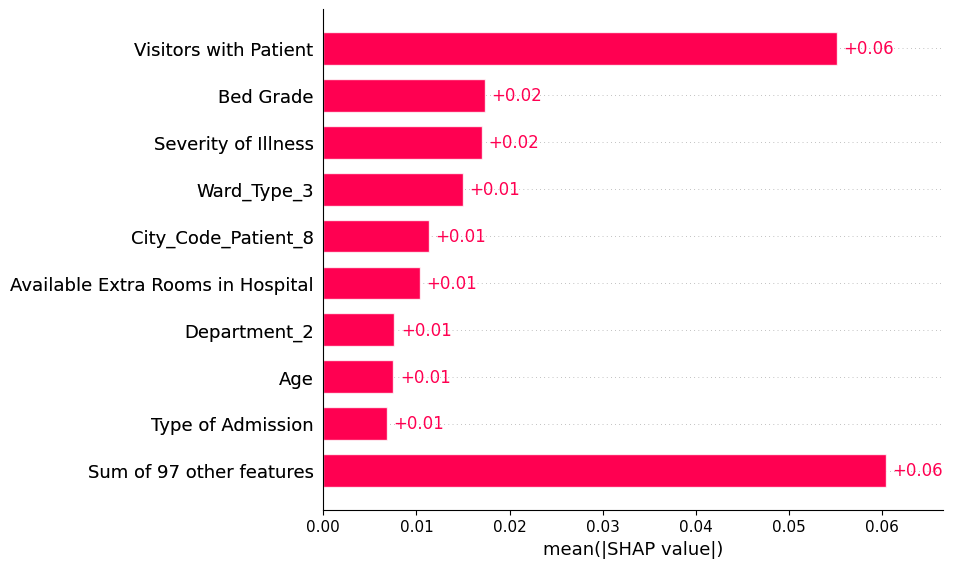


🔹 Class 2 SHAP Summary with SMOTE


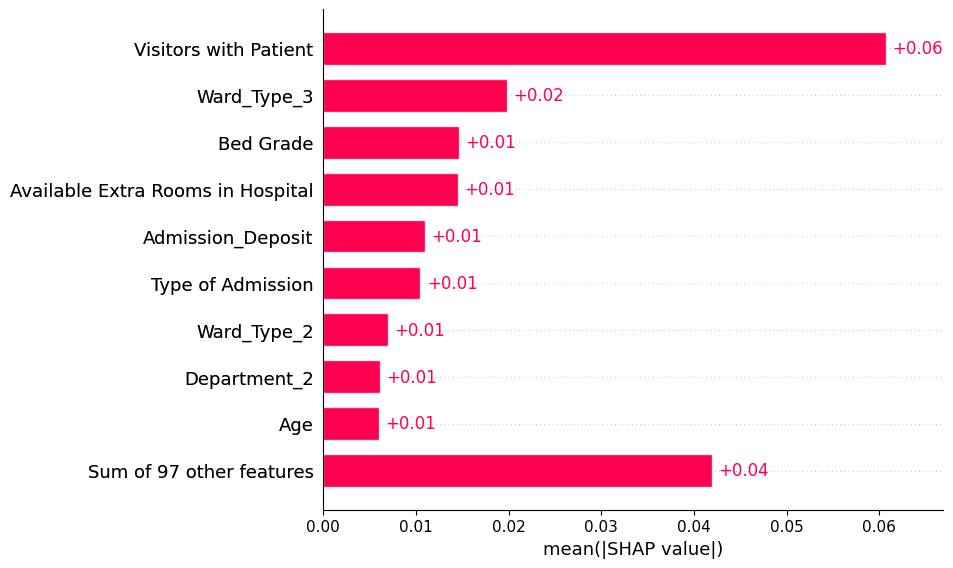


🔹 Class 3 SHAP Summary with SMOTE


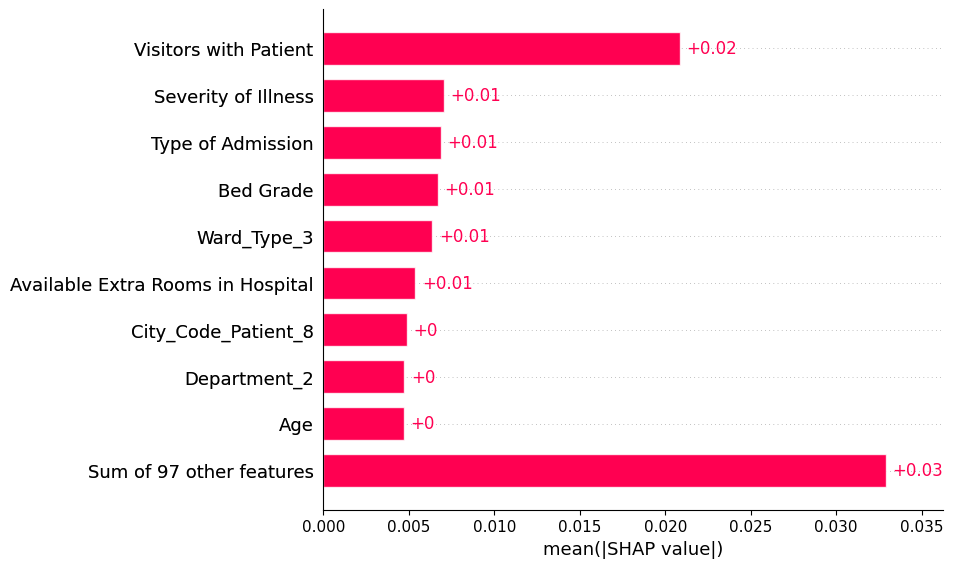


🔹 Class 4 SHAP Summary with SMOTE


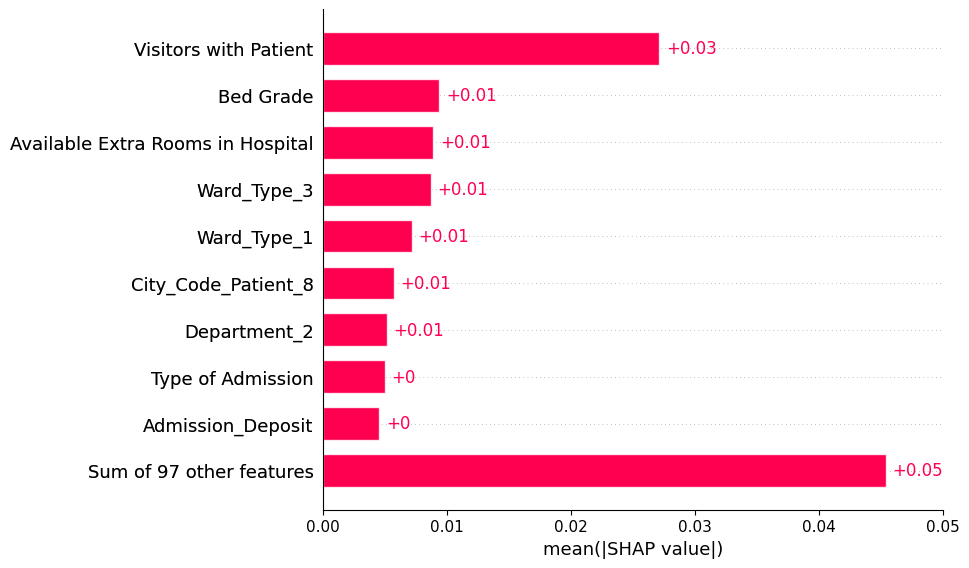


🔹 Class 5 SHAP Summary with SMOTE


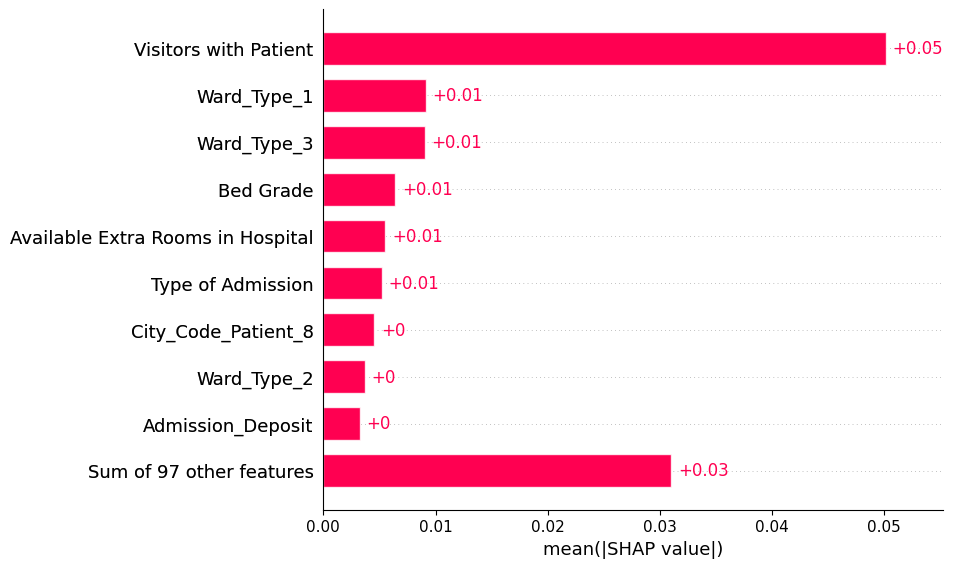


🔹 Class 6 SHAP Summary with SMOTE


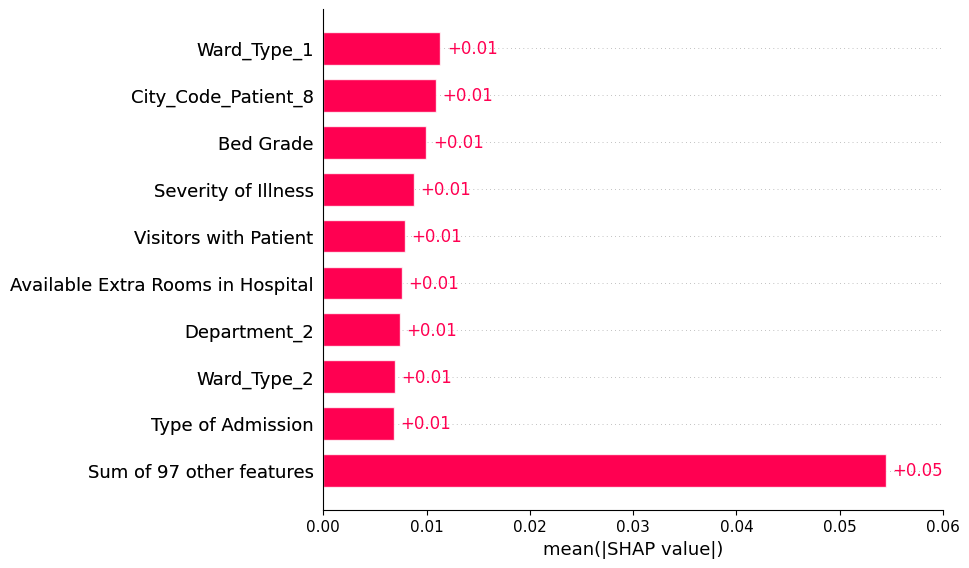


🔹 Class 7 SHAP Summary with SMOTE


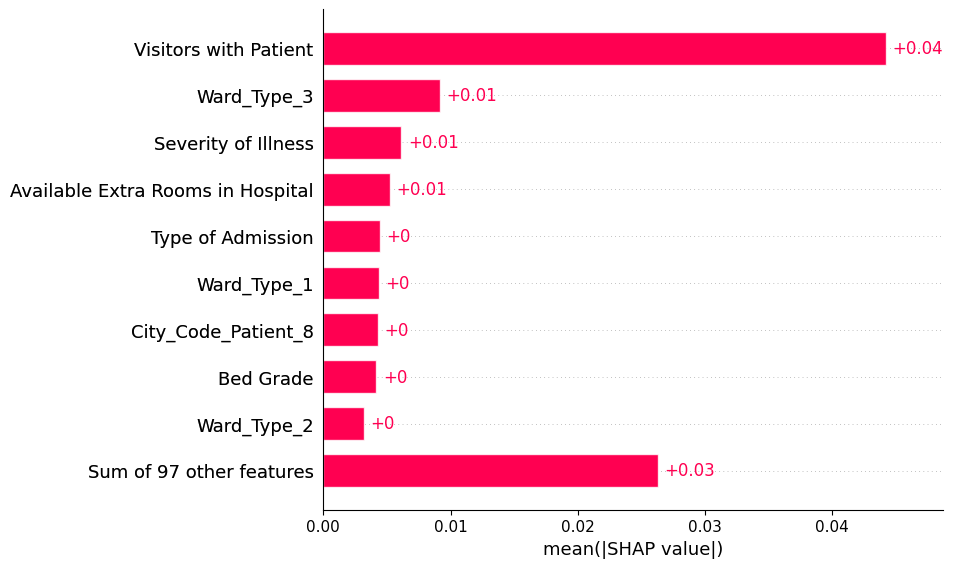


🔹 Class 8 SHAP Summary with SMOTE


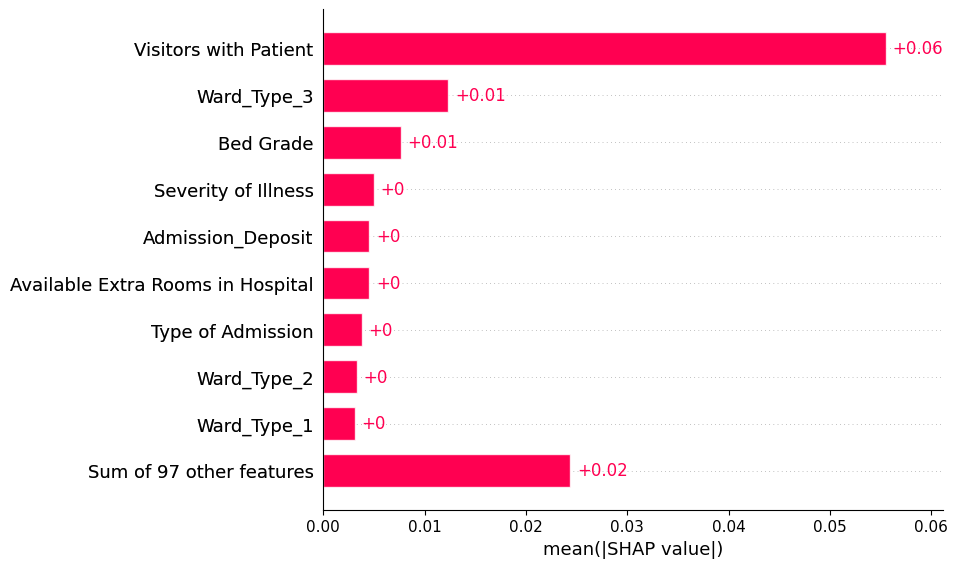


🔹 Class 9 SHAP Summary with SMOTE


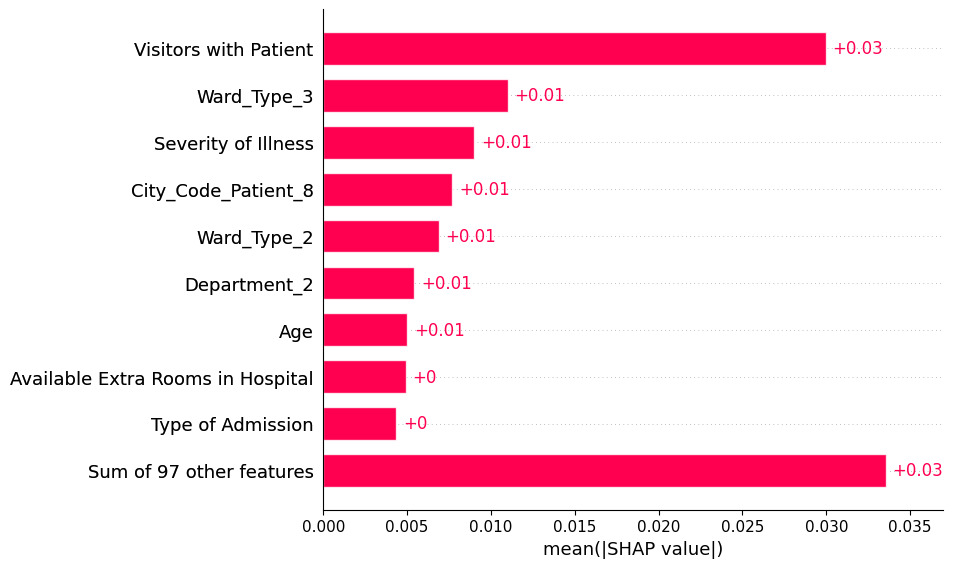


🔹 Class 10 SHAP Summary with SMOTE


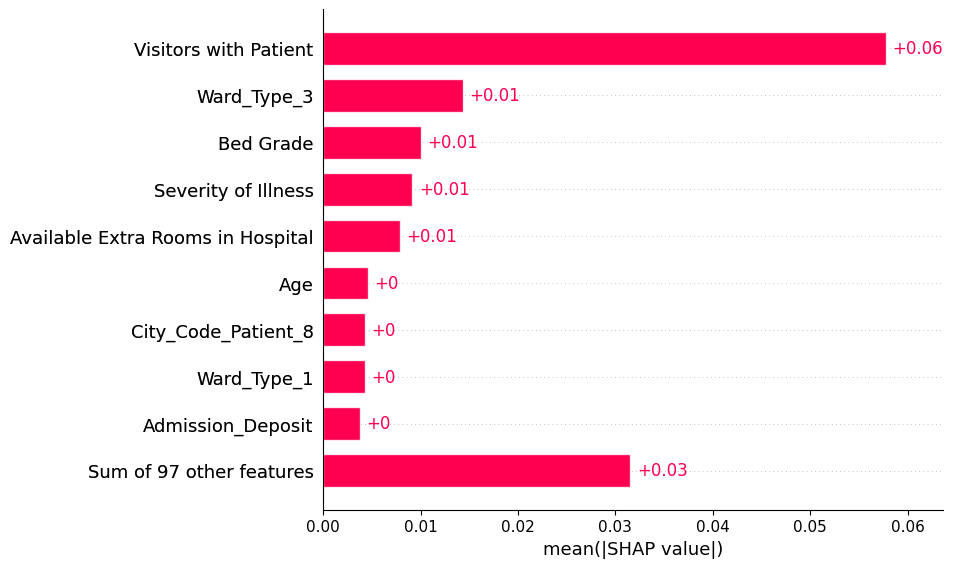

In [ ]:
# Sample some rows
sample_X = X_test_clean.sample(100, random_state=42).reset_index(drop=True)

# Use SHAP's newer explainer with probability output
explainer = shap.Explainer(rf_classifier.predict_proba, X_train_clean)

# Get SHAP values
shap_values = explainer(sample_X)

# Check output shape
print(" SHAP values shape:", shap_values.shape)  

# Plot top features for each class

for i in range(shap_values.shape[2]):  # loop over classes
    print(f"\n🔹 Class {i} SHAP Summary with SMOTE")
    shap.plots.bar(shap_values[:, :, i]) 




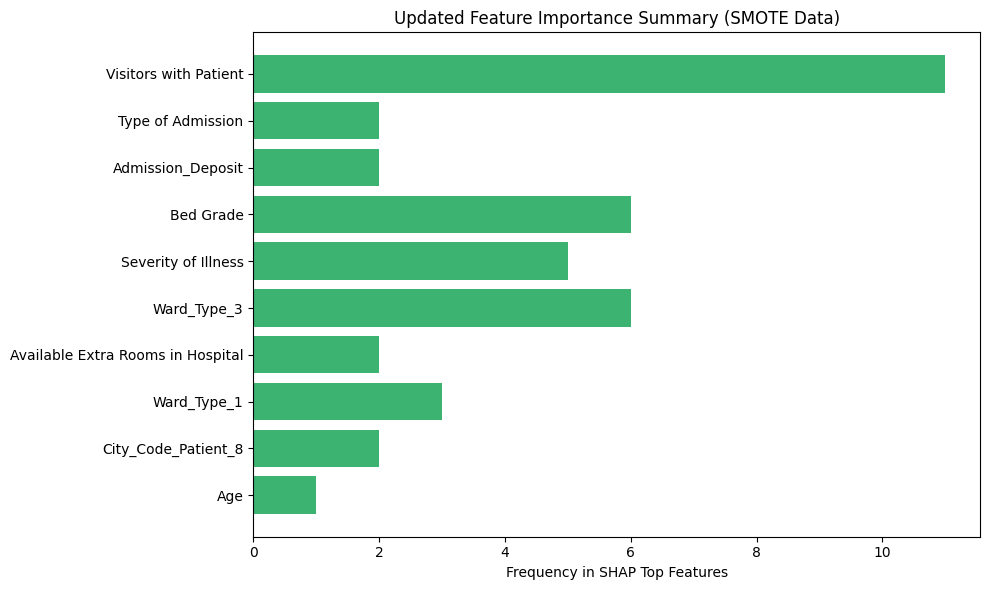

In [ ]:
# Add the new image's SHAP features to the SMOTE-based summary


smote_shap_top_features_updated = smote_shap_top_features + [
    ["Visitors with Patient", "Ward_Type_3", "Bed Grade", "Severity of Illness",
     "Available Extra Rooms in Hospital", "Age", "City_Code_Patient_8", "Ward_Type_1", "Admission_Deposit"]
]

# Flatten and recount
flat_smote_updated = [feature for sublist in smote_shap_top_features_updated for feature in sublist]
smote_feature_counts_updated = Counter(flat_smote_updated)

# Plot updated bar chart
features_smote_updated, counts_smote_updated = zip(*smote_feature_counts_updated.items())
plt.figure(figsize=(10, 6))
plt.barh(features_smote_updated, counts_smote_updated, color='mediumseagreen')
plt.xlabel("Frequency in SHAP Top Features")
plt.title("Updated Feature Importance Summary (SMOTE Data)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



In [ ]:
# Save the model to a file
joblib.dump(rf_classifier, 'random_forest_model2.pkl')

['random_forest_model2.pkl']

In [11]:
# Predict using the loaded model
y_pred = rf_classifier.predict(X_new)

In [12]:
stay_mapping = {
    0: "0-10",
    1: "11-20",
    2: "21-30",
    3: "31-40",
    4: "41-50",
    5: "51-60",
    6: "61-70",
    7: "71-80",
    8: "81-90",
    9: "91-100",
    10: "More than 100"
}

y_pred_labels = [stay_mapping[pred] for pred in y_pred] 
predictions_df = pd.DataFrame({
    "case_id": case_ids,
    "Stay": y_pred_labels
})

predictions_df.to_csv("predictions2.csv", index=False)

SHAP features for each class

In [ ]:
le = LabelEncoder()
y = le.fit_transform(train_data['Stay'])

# Now X and y match correctly
X = train_data.drop(columns=['Stay'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [20]:
# Convert all bool columns to int (0 and 1)
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

X_train_clean = X_train_clean.astype({col: int for col in X_train_clean.select_dtypes(bool).columns})
X_test_clean = X_test_clean.astype({col: int for col in X_test_clean.select_dtypes(bool).columns})



PermutationExplainer explainer: 101it [00:42,  1.85it/s]                         

 SHAP values shape: (100, 106, 11)

🔹 Class 0 SHAP Summary


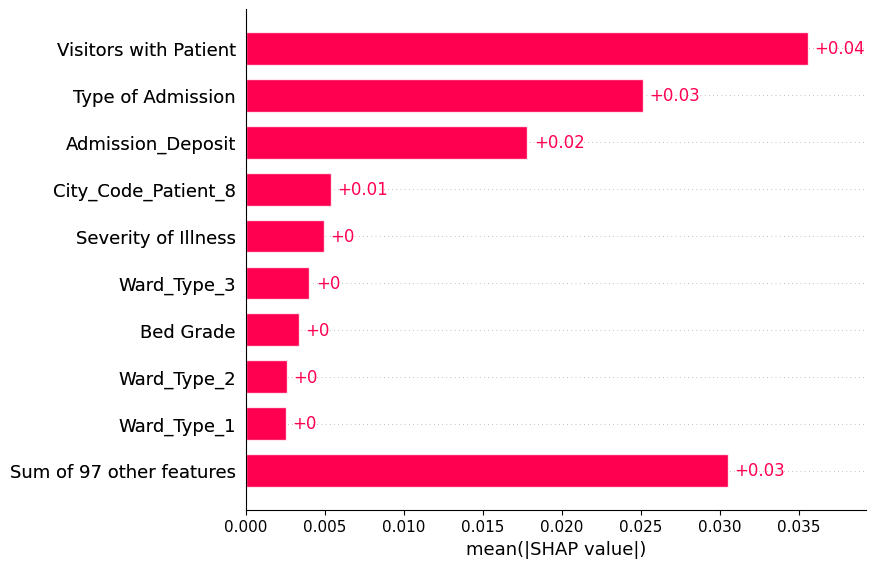


🔹 Class 1 SHAP Summary


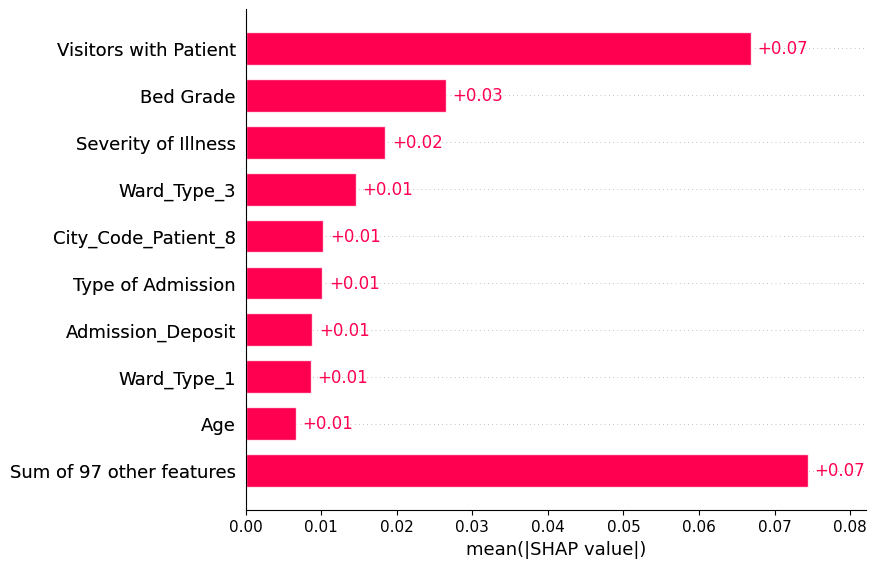


🔹 Class 2 SHAP Summary


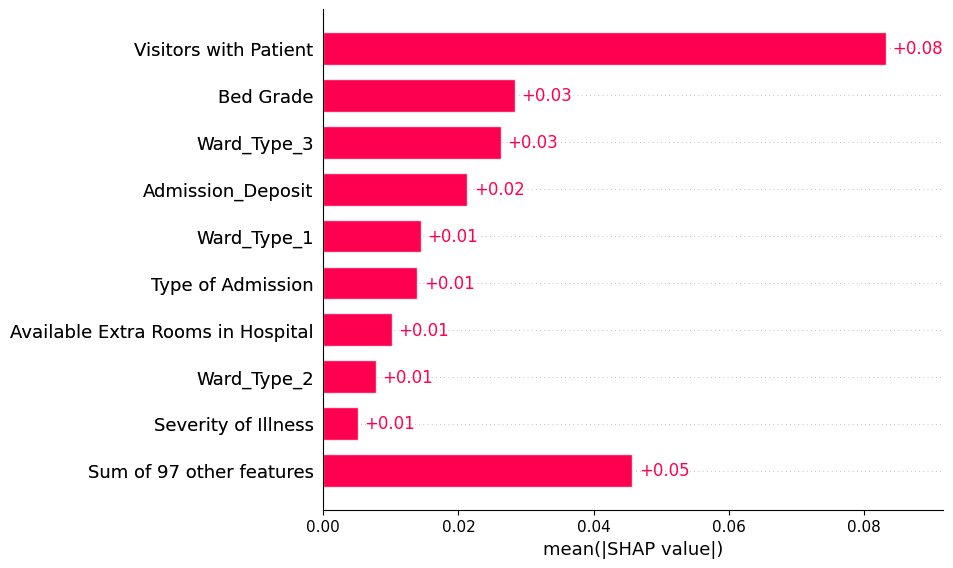


🔹 Class 3 SHAP Summary


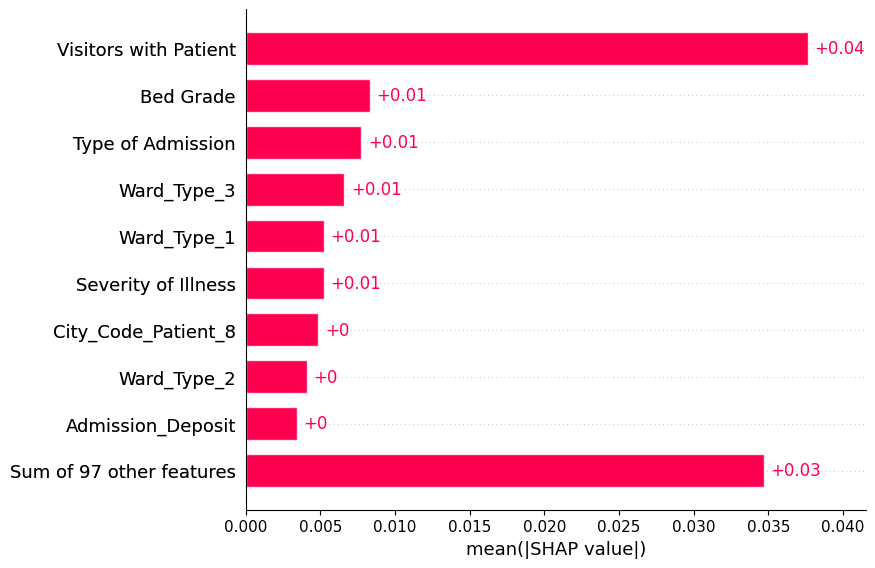


🔹 Class 4 SHAP Summary


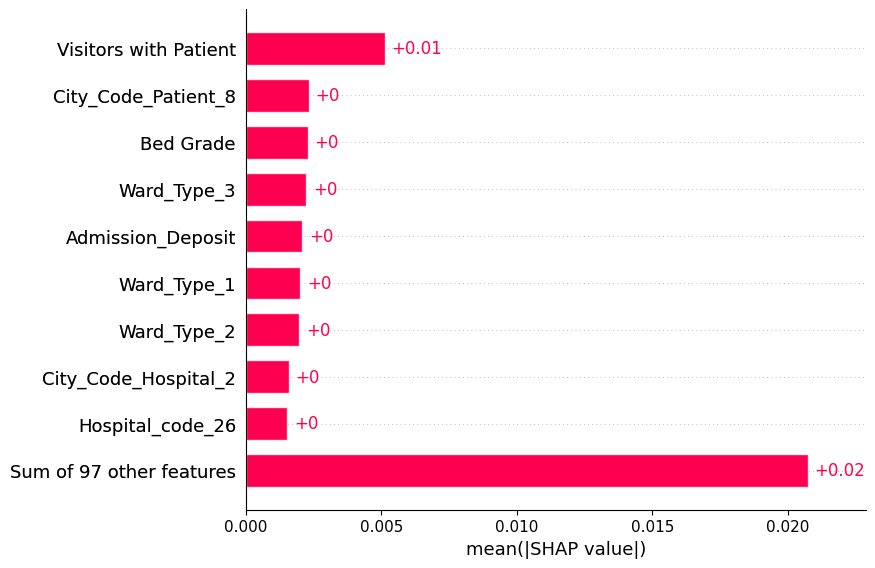


🔹 Class 5 SHAP Summary


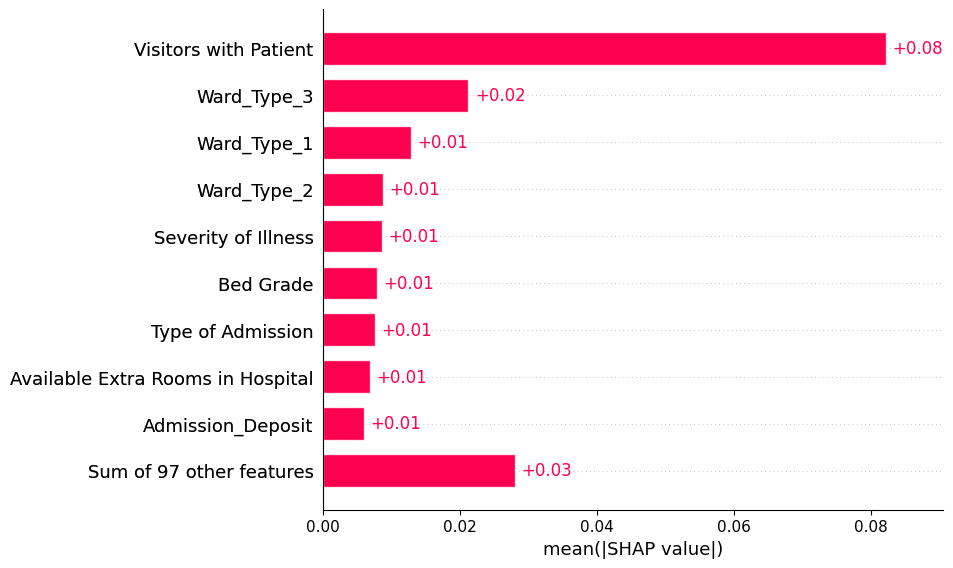


🔹 Class 6 SHAP Summary


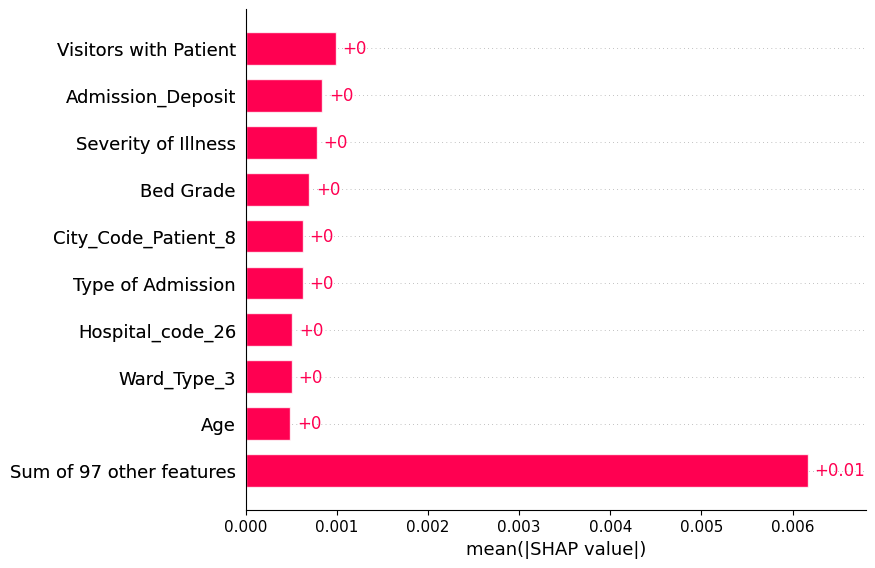


🔹 Class 7 SHAP Summary


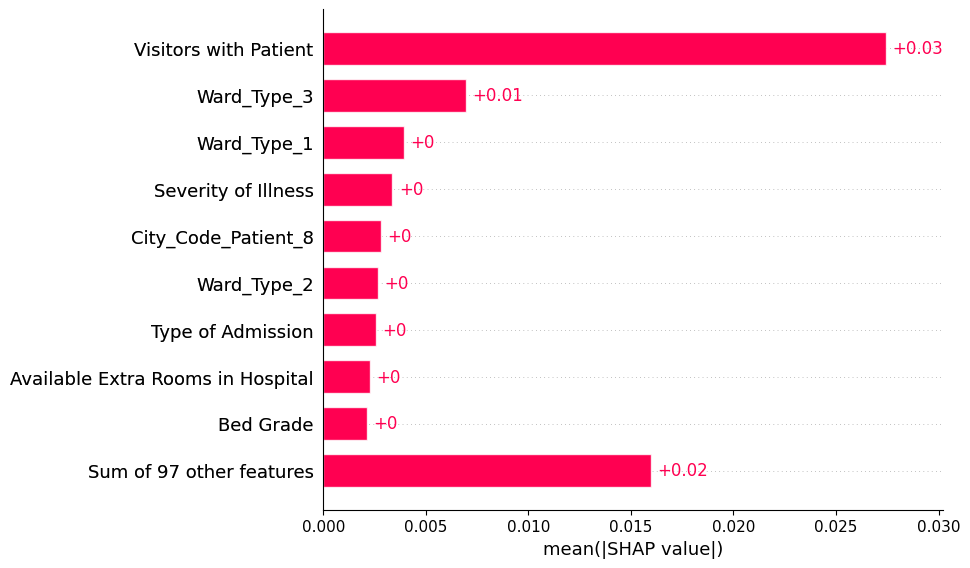


🔹 Class 8 SHAP Summary


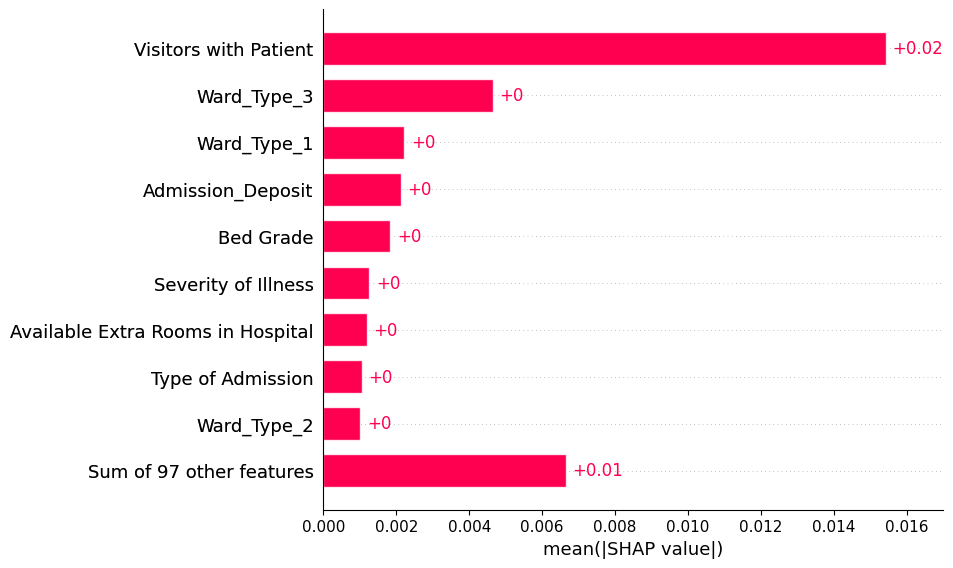


🔹 Class 9 SHAP Summary


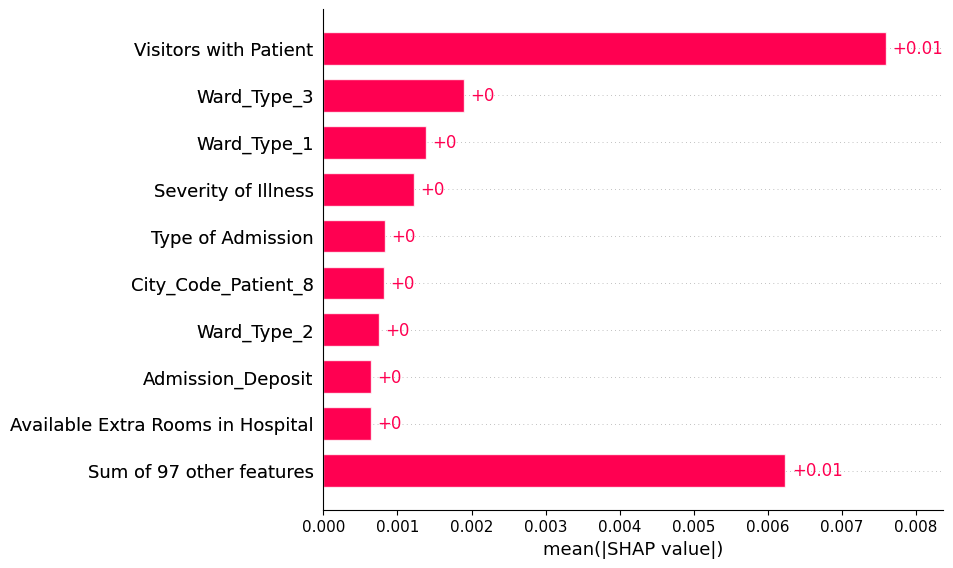


🔹 Class 10 SHAP Summary


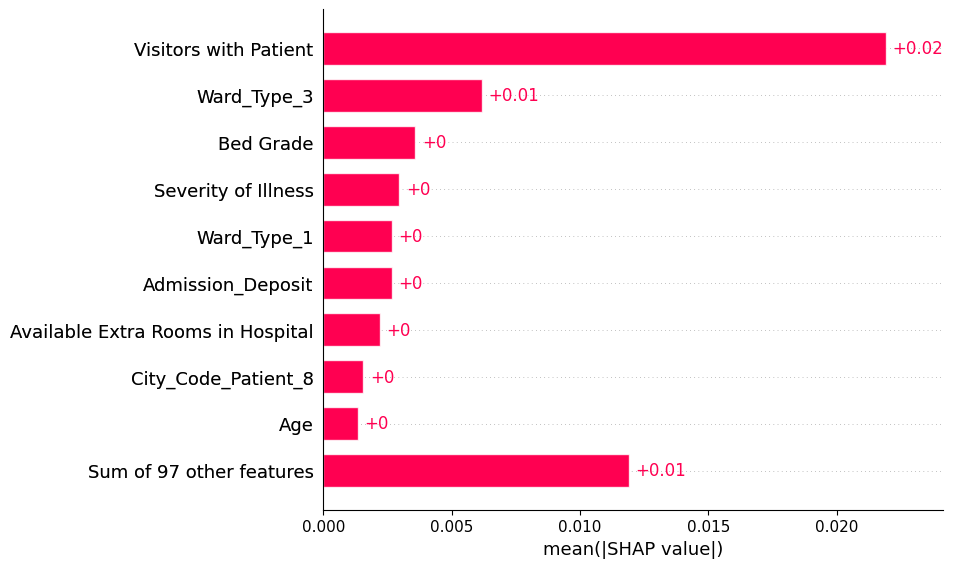

In [ ]:
# Sample some rows
sample_X = X_test_clean.sample(100, random_state=42).reset_index(drop=True)

# Use SHAP's newer explainer with probability output
explainer = shap.Explainer(rf_classifier.predict_proba, X_train_clean)

# Get SHAP values
shap_values = explainer(sample_X)

# Check output shape
print(" SHAP values shape:", shap_values.shape)  

# Plot top features for each class

for i in range(shap_values.shape[2]):  # loop over classes
    print(f"\n🔹 Class {i} SHAP Summary")
    shap.plots.bar(shap_values[:, :, i]) 




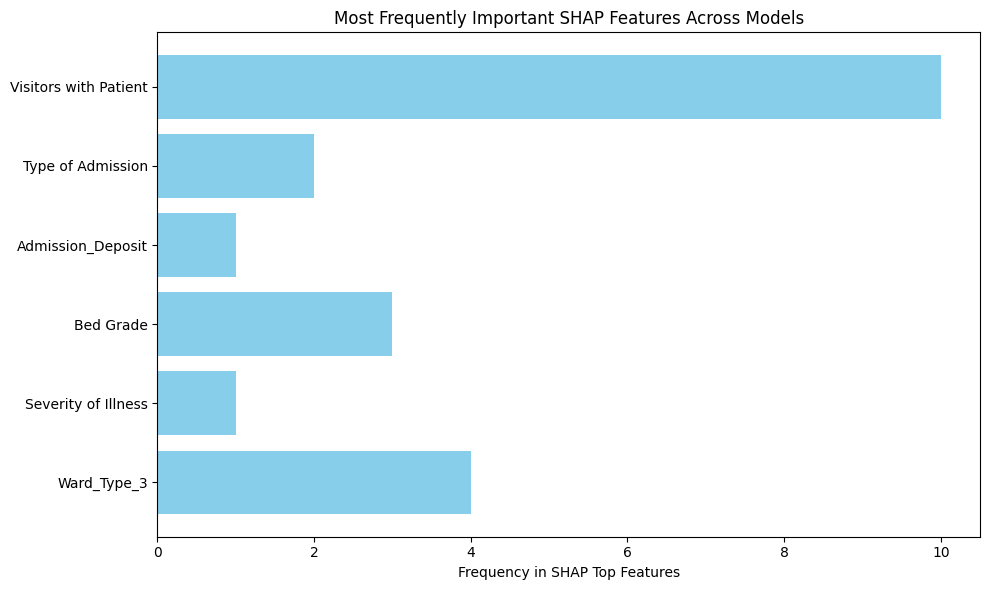

In [ ]:
#i lost the original code to make both of the SHAP charts so I had to improvise
shap_top_features = [
    ["Visitors with Patient", "Type of Admission", "Admission_Deposit"],
    ["Visitors with Patient", "Bed Grade", "Severity of Illness"],
    ["Visitors with Patient", "Bed Grade", "Ward_Type_3"],
    ["Visitors with Patient", "Bed Grade", "Type of Admission"],
    ["Visitors with Patient"],
    ["Visitors with Patient", "Ward_Type_3"],
    ["Visitors with Patient"],
    ["Visitors with Patient", "Ward_Type_3"],
    ["Visitors with Patient"],
    ["Visitors with Patient", "Ward_Type_3"]
]

# Flatten and count frequency
flat_features = [feature for sublist in shap_top_features for feature in sublist]
feature_counts = Counter(flat_features)

# Plotting top feature occurrences
features, counts = zip(*feature_counts.items())
plt.figure(figsize=(10, 6))
plt.barh(features, counts, color='skyblue')
plt.xlabel("Frequency in SHAP Top Features")
plt.title("Most Frequently Important SHAP Features Across Models")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


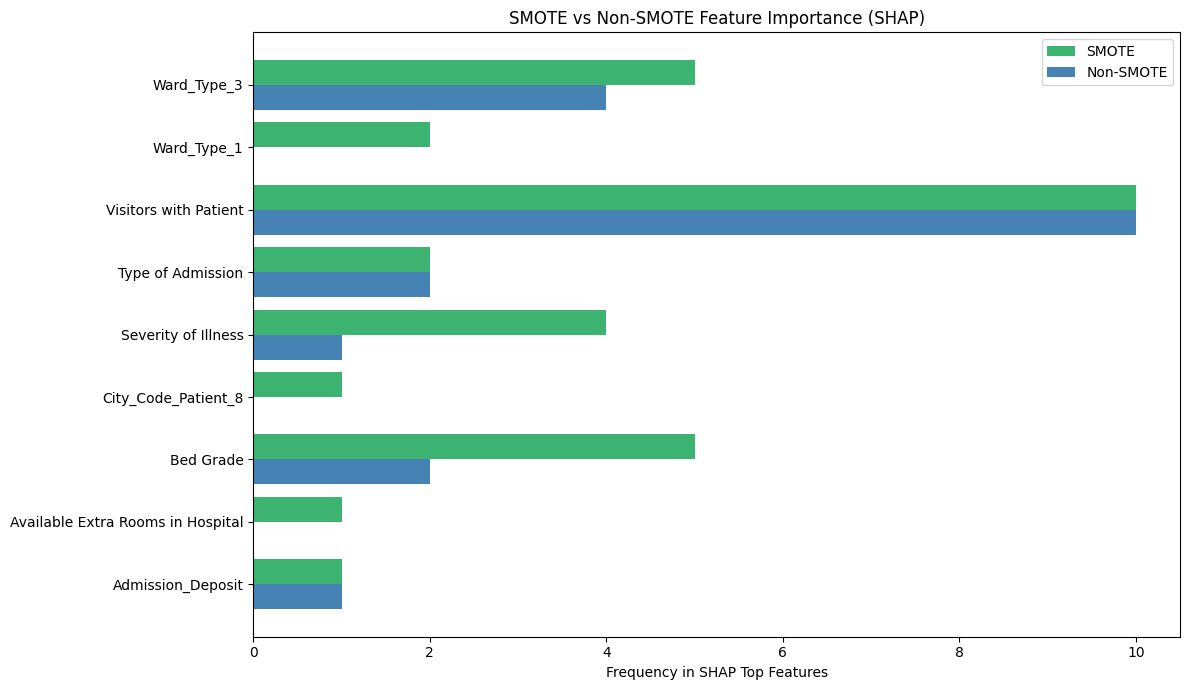

In [ ]:
# Reconstructing the original (non-SMOTE) SHAP top features for comparison
non_smote_shap_top_features = [
    ["Visitors with Patient", "Type of Admission", "Admission_Deposit"],
    ["Visitors with Patient", "Bed Grade", "Severity of Illness"],
    ["Visitors with Patient", "Ward_Type_3"],
    ["Visitors with Patient", "Bed Grade", "Type of Admission"],
    ["Visitors with Patient"],
    ["Visitors with Patient", "Ward_Type_3"],
    ["Visitors with Patient"],
    ["Visitors with Patient", "Ward_Type_3"],
    ["Visitors with Patient"],
    ["Visitors with Patient", "Ward_Type_3"]
]

# Flatten and count
flat_non_smote = [feature for sublist in non_smote_shap_top_features for feature in sublist]
non_smote_counts = Counter(flat_non_smote)

# Combine both into a comparison-friendly format
all_features = set(flat_non_smote + flat_smote_features)
comparison_data = {
    "Feature": [],
    "SMOTE Frequency": [],
    "Non-SMOTE Frequency": []
}

for feature in sorted(all_features):
    comparison_data["Feature"].append(feature)
    comparison_data["SMOTE Frequency"].append(smote_feature_counts.get(feature, 0))
    comparison_data["Non-SMOTE Frequency"].append(non_smote_counts.get(feature, 0))



df_comparison = pd.DataFrame(comparison_data)

# Plot side-by-side bar chart
plt.figure(figsize=(12, 7))
bar_width = 0.4
x = range(len(df_comparison))

plt.barh(
    [i + bar_width for i in x],
    df_comparison["SMOTE Frequency"],
    height=bar_width,
    label="SMOTE",
    color="mediumseagreen"
)

plt.barh(
    x,
    df_comparison["Non-SMOTE Frequency"],
    height=bar_width,
    label="Non-SMOTE",
    color="steelblue"
)

plt.yticks([i + bar_width / 2 for i in x], df_comparison["Feature"])
plt.xlabel("Frequency in SHAP Top Features")
plt.title("SMOTE vs Non-SMOTE Feature Importance (SHAP)")
plt.legend()
plt.tight_layout()
plt.show()
